# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "P0_example1.mp4" (also contained in this repository) to see what the output should look like. 

Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the lines in the image, and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="laneLines_thirdPass.jpg" width="480" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output image should look like this (more or less) after line detection </p> 
 </figcaption>
</figure>

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [ ]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

**Note** that in the above image, the vertices of interest appear to be:
(100, 540), (480, 300), and (900, 540)

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_noise(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    Draws `lines` with `color` and `thickness`.
    
    Lines are drawn on the image inplace (mutates the image).
    """
    if lines == None:
        return
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['challenge_shadows.jpg',
 'challenge.jpg',
 'challenge_shadows2.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteCurve.jpg',
 'challenge_bridge.jpg',
 'solidWhiteRight.jpg',
 'challenge_shadows3.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg']

(Note that I added two `challenge` jpgs for use in the optional part of this assignment.  They will be ignored until that part.)

run your solution on all test_images and make copies into the test_images directory).

### Defining a Region of Interest
First, we'll want to ensure that we're defining our region of interest correctly.
The below code should help to mask off only the area of the image (and later, video) that we'll care about processing.

In [ ]:
# Vertices from above
vertices = np.array([[(100, 540), (440, 320), (520, 320), (900, 540)]])
masked_image = region_of_interest(image, vertices)

#printing out some stats and plotting
print('The masked image is:', type(masked_image), 'with dimensions:', masked_image.shape)
plt.imshow(masked_image)

### Applying the Canny Transform
Next, we'll want to ensure that we're filtering out everything we can except for the lane lines themselves.  
This isn't always possible, but the more we can successfully filter out noise, the easier it will be to draw the Hough lines.

In [ ]:
canny_image = canny(image, 255, 255)

#printing out some stats and plotting
print('The Canny-Transformed image is:', type(canny_image), 'with dimensions:', canny_image.shape)
plt.imshow(canny_image, cmap='gray')

From repeated trials with different `low_threshold` and `high_threshold` values, it would appear that using `255, 255` filters out most of the noise while leaving the existing lane lines visible.

### Drawing the Hough Lines
First off, let's combine the results of the above two sections into a single image:

In [ ]:
masked_canny_image = region_of_interest(canny_image, vertices)

#printing out some stats and plotting
print('The masked, Canny-Transformed image is:', type(masked_canny_image),
      'with dimensions:', masked_canny_image.shape)
plt.imshow(masked_canny_image, cmap='gray')

Now we're looking at just the lane lines, as identified by the Canny transformation. Cool!  
We'll use this image to draw the Hough lines.

In [ ]:
# Apply a Gaussian Noise filter, or else the lines are more difficult to detect
gaussian_image = gaussian_noise(masked_canny_image, 5)

# Draw the Hough Lines
hough_image = hough_lines(gaussian_image, rho = 1, theta = np.pi / 180, threshold = 50,
                          min_line_len = 100, max_line_gap = 150)
# See, e.g., http://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/hough_lines/hough_lines.html,
# especially 4. Probabilistic Hough Line Transform

#printing out some stats and plotting
print('The image with Hough Lines drawn is:', type(hough_image), 'with dimensions:', hough_image.shape)
plt.imshow(hough_image, cmap='gray')

Next, we'll superimpose these Hough Lines on our original image, so that the humans know that the car knows where the lane lines are.

In [ ]:
# Transform the hough_image into the same channel space.
# Or else, cv2.addWeighted will fail.
hough_image_BGR = cv2.cvtColor(hough_image, cv2.COLOR_GRAY2BGR)

# Make the Hough Lines pink, because I like pink.
b,g,r = cv2.split(hough_image_BGR)
g = 0 * g
b * 0.5 * b
hough_image_pink = cv2.merge((b, g, r))
# See, e.g., http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_core/py_basic_ops/py_basic_ops.html

# Superimpose the Hough Lines on the original image
# Using the default parameters for α, β, and λ
superimposed_image = weighted_img(hough_image_pink, image, α=0.8, β=1., λ=0.1)

#printing out some stats and plotting
print('The original image with Hough Lines superimposed is:', type(superimposed_image),
      'with dimensions:', superimposed_image.shape)
plt.imshow(superimposed_image, cmap='gray')

Seems like we've got a good first try, let's build a pipeline and apply it to all the images in the `test_images` directory.

In [ ]:
def process_image(image):
    # Apply the Canny Transform
    canny_image = canny(image, 255, 255)

    # Mask the Region of Interest
    vertices = np.array([[(100, 540), (440, 325), (520, 325), (900, 540)]])
    masked_canny_image = region_of_interest(canny_image, vertices)

    # Apply a Gaussian Noise filter
    gaussian_image = gaussian_noise(masked_canny_image, 5)

    # Draw the Hough Lines
    hough_image = hough_lines(gaussian_image, rho = 1, theta = np.pi / 180, threshold = 50,
                          min_line_len = 100, max_line_gap = 150)

    # Transform the hough_image into the same channel space.
    # Or else, cv2.addWeighted will fail.
    hough_image_BGR = cv2.cvtColor(hough_image, cv2.COLOR_GRAY2BGR)

    # Make the Hough Lines pink, because I like pink.
    b,g,r = cv2.split(hough_image_BGR)
    g = 0 * g
    b * 0.5 * b
    hough_image_pink = cv2.merge((b, g, r))
    # See, e.g., http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_core/py_basic_ops/py_basic_ops.html

    # Superimpose the Hough Lines on the original image
    # Using the default parameters for α, β, and λ
    superimposed_image = weighted_img(hough_image_pink, image, α=0.8, β=1., λ=0.1)

    return superimposed_image

In [ ]:
test_list = os.listdir("test_images/")
for file in test_list:
    if "challenge" in file:
        continue
    img = mpimg.imread('test_images/' + file)
    print('This image is:', type(img), 'with dimensions:', img.shape)
    after_img = process_image(img)
    plt.figure()
    plt.title(file)
    plt.imshow(after_img)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P0_example1.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

#### Slope Extension
If our Hough Transform yields a line, it's probably a lane line.  As such, it almost certainly extends to the bottom of the frame.  Accordingly, draw lines that we find to the bottom of the frame.

In [7]:
def toBottom(shape, x1, y1, x2, y2, slope):
    """
    Given x and y coordinates representing segments of a lane line,
    and a tuple representing the dimensions of the given image,
    returns the line which is drawn to the bottom of the image's frame
    """
    bottom = shape[0]
    right = shape[1]
    if slope < 0:
        # replace x1 and y1
        y1 = bottom
        x1 = int(x2 - (y2 - y1) / slope)
    elif slope > 0:
        # replace x2 and y2
        y2 = bottom
        x2 = int(x1 + (y2 - y1) / slope)
        
    return x1, y1, x2, y2

#### Slope-Threshold Rejection
Let's assume that a lane line is going to be within a narrow range of slopes.  That is to say, we're not going to have completely vertical lane lines (they'll be to one side or the other, we won't be driving on top of one) and we're not going to have completely horizontal lane lines (if we have somehow turned 90&deg; in our lane, we have bigger problems than lane line detection).

Accordingly, let's see what that threshold might be, and reject Hough Transform-generated lines that are outside of that range.

In [ ]:
def get_hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap):
    # Apply Canny Edge Detection
    canny_image = canny(image, 255, 255)

    # Mask the Region of Interest
    vertices = np.array([[(100, 540), (440, 325), (520, 325), (900, 540)]])
    masked_canny_image = region_of_interest(canny_image, vertices)

    # Apply a Gaussian Noise filter
    gaussian_image = gaussian_noise(masked_canny_image, 5)

    # Find the Hough Lines
    lines = cv2.HoughLinesP(gaussian_image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    return lines

In [ ]:
test_list = os.listdir("test_images/")
slopes = []
for file in test_list:
    if "challenge" in file:
        continue
    img = mpimg.imread('test_images/' + file)
    
    hough_lines = get_hough_lines(img, rho = 1, theta = np.pi / 180, threshold = 50,
                          min_line_len = 100, max_line_gap = 150)
    for line in hough_lines:
        for x1,y1,x2,y2 in line:
            slopes.append(abs((y2 - y1) / (x2 - x1)))

plt.hist(slopes, bins = 20)
plt.xlim(0,1)
plt.xticks(np.arange(0, 1, 0.1))
plt.title("Magnitude of Hough Transform-Generated Line Slopes")
plt.xlabel("Magnitude of Slope\n(y2 - y1) / (x2 - x1)")
plt.ylabel("Frequency of Occurrence")
plt.show()

From the above, it would seem that a sensible slope range would be **0.50 to 0.85**.

Anything steeper or shallower is probably not a lane line, even though it is a line generated by the Hough Transform, and so we probably don't want to overlay it on our image.

#### Incorporating Slope Extension and Slope-Threshold Rejection
Below is the pipeline from above, modified to include our new concepts of **slope extension** and **slope-threshold rejection**.

In [8]:
def draw_lines_to_bottom(img, lines, color=[255, 0, 0], thickness=2):
    """
    Draws `lines` with `color` and `thickness`.
    
    Lines are drawn on the image inplace (mutates the image).
    """
    if lines == None:
        return
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            if 0.50 < abs(slope) < 0.85:
                nx1, ny1, nx2, ny2 = toBottom(img.shape, x1, y1, x2, y2, slope)
                cv2.line(img, (nx1, ny1), (nx2, ny2), color, thickness)

In [9]:
def hough_lines_to_bottom(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines_to_bottom(line_img, lines)
    return line_img


In [ ]:
def process_image_to_bottom(image):
    # Apply the Canny Transform
    canny_image = canny(image, 255, 255)

    # Mask the Region of Interest
    vertices = np.array([[(100, 540), (440, 325), (520, 325), (900, 540)]])
    masked_canny_image = region_of_interest(canny_image, vertices)

    # Apply a Gaussian Noise filter
    gaussian_image = gaussian_noise(masked_canny_image, 5)

    # Draw the Hough Lines
    hough_image = hough_lines_to_bottom(gaussian_image, rho = 1, theta = np.pi / 180, threshold = 50,
                          min_line_len = 100, max_line_gap = 150)

    # Transform the hough_image into the same channel space.
    # Or else, cv2.addWeighted will fail.
    hough_image_BGR = cv2.cvtColor(hough_image, cv2.COLOR_GRAY2BGR)

    # Make the Hough Lines pink, because I like pink.
    b,g,r = cv2.split(hough_image_BGR)
    g = 0 * g
    b * 0.5 * b
    hough_image_pink = cv2.merge((b, g, r))
    # See, e.g., http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_core/py_basic_ops/py_basic_ops.html

    # Superimpose the Hough Lines on the original image
    # Using the default parameters for α, β, and λ
    superimposed_image = weighted_img(hough_image_pink, image, α=0.8, β=1., λ=0.1)

    return superimposed_image

In [ ]:
test_list = os.listdir("test_images/")
for file in test_list:
    if "challenge" in file:
        continue
    img = mpimg.imread('test_images/' + file)
    print('This image is:', type(img), 'with dimensions:', img.shape)
    after_img = process_image_to_bottom(img)
    plt.figure()
    plt.title(file)
    plt.imshow(after_img)

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image_to_bottom)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


**1.** ~~Should the lane lines be crossing over each other near the horizon?  If not, is the solution merely to shrink the Region of Interest?~~  

   I noticed that the lane lines were crossing over each other near the horizon.  My solution for this was simply to lower the upper portion of the region of interest.

**2.** ~~For striped lane markers, how can the Hough Lines be drawn so that they stretch to the bottom of the frame?~~  
Previously, lane lines had gaps when the most recent stripe disappears, which isn't ideal.  The solution to this was to assume that, if a Hough line was found, then that line can be assumed to represent an unbroken lane line plane, and so can be extended to the bottom of the video frame.  

   The issue with this assumpion is, of course, that it would incorrectly represent curves and turns, which would not be **linear** but rather **curvilinear**, perhaps best represented by a quadratic or other conic equation.

## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
#reading in the challenge image
challenge_image = mpimg.imread('test_images/challenge.jpg')
#printing out some stats and plotting
print('This image is:', type(challenge_image), 'with dimensions:', challenge_image.shape)
plt.imshow(challenge_image)

### Defining a New Region of Interest
The challenge video is a different size than are the videos and images we have been working with so far.  
Accordingly, using the pipeline we have defined above is going to lead to some issues:

In [ ]:
# Vertices from above pipeline
challenge_vertices = np.array([[(100, 540), (440, 320), (520, 320), (900, 540)]])
challenge_masked_image = region_of_interest(challenge_image, challenge_vertices)

#printing out some stats and plotting
print('The masked image is:', type(challenge_masked_image), 'with dimensions:', challenge_masked_image.shape)
plt.imshow(challenge_masked_image)

Accordingly, let's redefine the region of interest as such:

In [ ]:
# Define new vertices
challenge_vertices = np.array([[(120, 738), (580, 450), (740, 450), (1250, 738)]])
challenge_masked_image = region_of_interest(challenge_image, challenge_vertices)

#printing out some stats and plotting
print('The masked image is:', type(challenge_masked_image), 'with dimensions:', challenge_masked_image.shape)
plt.imshow(challenge_masked_image)

### Updating our Pipeline with the New Region of Interest

In [ ]:
def process_challenge_image(image):
    # Apply the Canny Transform
    canny_image = canny(image, 255, 255)

    # Mask the Region of Interest
    vertices = np.array([[(120, 738), (580, 450), (740, 450), (1250, 738)]])
    masked_canny_image = region_of_interest(canny_image, vertices)

    # Apply a Gaussian Noise filter
    gaussian_image = gaussian_noise(masked_canny_image, 5)

    # Draw the Hough Lines
    hough_image = hough_lines_to_bottom(gaussian_image, rho = 1, theta = np.pi / 180, threshold = 50,
                          min_line_len = 100, max_line_gap = 150)

    # Transform the hough_image into the same channel space.
    # Or else, cv2.addWeighted will fail.
    hough_image_BGR = cv2.cvtColor(hough_image, cv2.COLOR_GRAY2BGR)

    # Make the Hough Lines pink, because I like pink.
    b,g,r = cv2.split(hough_image_BGR)
    g = 0 * g
    b * 0.5 * b
    hough_image_pink = cv2.merge((b, g, r))
    # See, e.g., http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_core/py_basic_ops/py_basic_ops.html

    # Superimpose the Hough Lines on the original image
    # Using the default parameters for α, β, and λ
    superimposed_image = weighted_img(hough_image_pink, image, α=0.8, β=1., λ=0.1)

    return superimposed_image

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_challenge_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

### Analysis and Thoughts
Pretty impressive!
Except we're:
1. Having a hard time detecting the yellow lane line when we enter the gray-pavement bridge, and
2. We're finding lane lines that aren't really there.

Maybe we can tune some of the parameters of our pipeline to correct these errors.

### Removing erroneous lane lines
To fix `2.`, let's reduce `min_line_len`, `max_line_gap`, and the kernel size for our Gaussian Noise Filter.

In [ ]:
def process_challenge_image(image):
    # Apply the Canny Transform
    canny_image = canny(image, 255, 255)

    # Mask the Region of Interest
    vertices = np.array([[(120, 738), (580, 450), (740, 450), (1250, 738)]])
    masked_canny_image = region_of_interest(canny_image, vertices)

    # Apply a Gaussian Noise filter
    gaussian_image = gaussian_noise(masked_canny_image, 3)

    # Draw the Hough Lines
    hough_image = hough_lines_to_bottom(gaussian_image, rho = 1, theta = np.pi / 180, threshold = 50,
                          min_line_len = 50, max_line_gap = 75)

    # Transform the hough_image into the same channel space.
    # Or else, cv2.addWeighted will fail.
    hough_image_BGR = cv2.cvtColor(hough_image, cv2.COLOR_GRAY2BGR)

    # Make the Hough Lines pink, because I like pink.
    b,g,r = cv2.split(hough_image_BGR)
    g = 0 * g
    b * 0.5 * b
    hough_image_pink = cv2.merge((b, g, r))
    # See, e.g., http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_core/py_basic_ops/py_basic_ops.html

    # Superimpose the Hough Lines on the original image
    # Using the default parameters for α, β, and λ
    superimposed_image = weighted_img(hough_image_pink, image, α=0.8, β=1., λ=0.1)

    return superimposed_image

In [ ]:
challenge_output = 'extra1.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_challenge_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

### Strengthening Weak Lane Line Detection
To better detect the yellow lane line, let's tweak our Canny Edge Detection

In [177]:
def process_challenge_image(image):
    # Apply the Canny Transform
    canny_image = canny(image, 255, 255)
    canny_image_with_yellows = canny_image + threshold_yellow(image)

    # Mask the Region of Interest
    vertices = np.array([[(120, 738), (580, 450), (740, 450), (1250, 738)]])
    masked_canny_image = region_of_interest(canny_image_with_yellows, vertices)

    # Apply a Gaussian Noise filter
    gaussian_image = gaussian_noise(masked_canny_image, 5)
    
    # Draw the Hough Lines
    hough_image = hough_lines_to_bottom(gaussian_image, rho = 1, theta = np.pi / 180, threshold = 65,
                          min_line_len = 50, max_line_gap = 75)

    # Transform the hough_image into the same channel space.
    # Or else, cv2.addWeighted will fail.
    hough_image_BGR = cv2.cvtColor(hough_image, cv2.COLOR_GRAY2BGR)

    # Make the Hough Lines pink, because I like pink.
    b,g,r = cv2.split(hough_image_BGR)
    g = 0 * g
    b * 0.5 * b
    hough_image_pink = cv2.merge((b, g, r))
    # See, e.g., http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_core/py_basic_ops/py_basic_ops.html

    # Superimpose the Hough Lines on the original image
    # Using the default parameters for α, β, and λ
    superimposed_image = weighted_img(hough_image_pink, image, α=0.8, β=1., λ=0.1)

    return superimposed_image

This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)


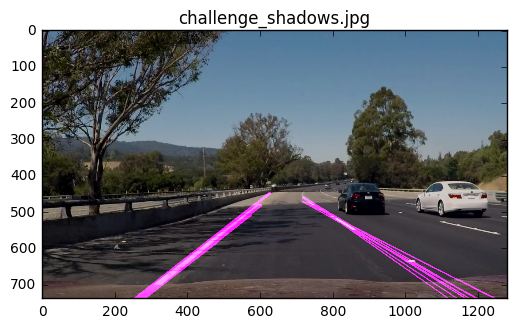

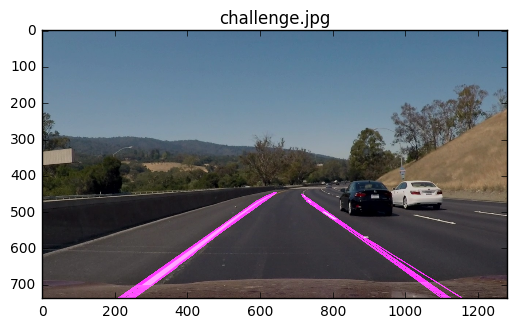

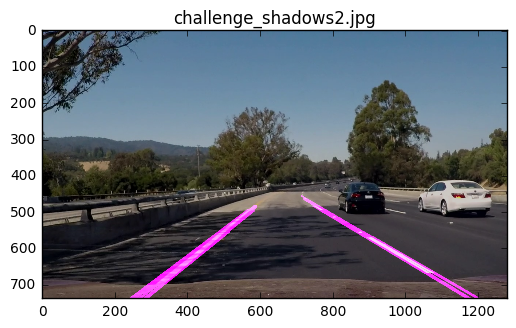

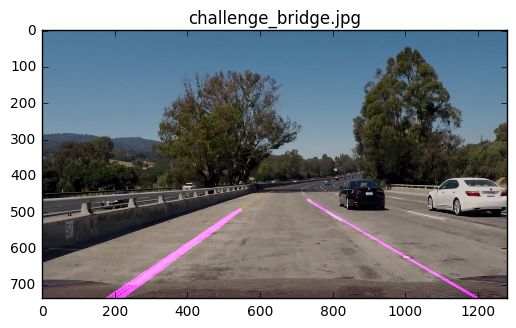

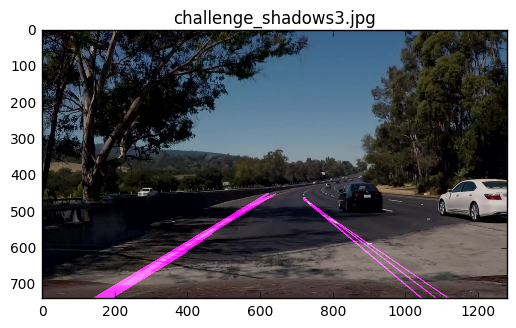

In [178]:
test_list = os.listdir("test_images/")
for file in test_list:
    if "challenge" not in file:
        continue
    img = mpimg.imread('test_images/' + file)
    print('This image is:', type(img), 'with dimensions:', img.shape)
    after_img = process_challenge_image(img)
    plt.figure()
    plt.title(file)
    plt.imshow(after_img)

In [22]:
challenge_output = 'extra_bridge.mp4'
clip2 = VideoFileClip('challenge_bridge.mp4')
challenge_clip = clip2.fl_image(process_challenge_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra_bridge.mp4
[MoviePy] Writing video extra_bridge.mp4


100%|██████████| 76/76 [00:05<00:00, 13.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra_bridge.mp4 

CPU times: user 8.99 s, sys: 257 ms, total: 9.25 s
Wall time: 7.23 s


This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)


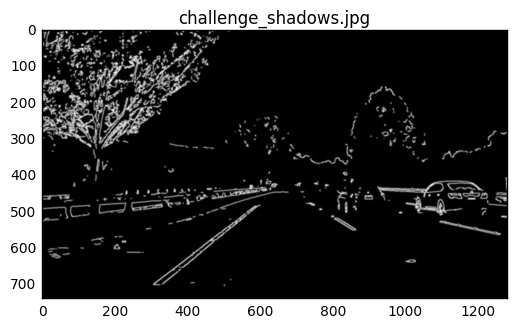

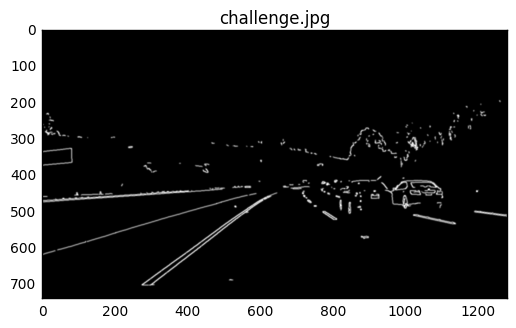

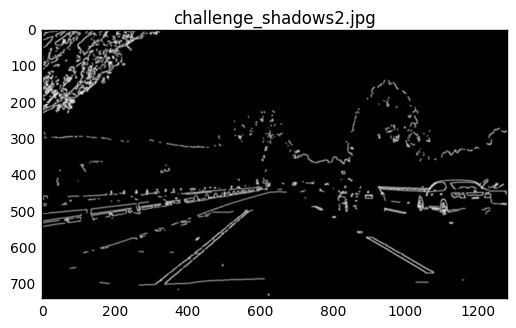

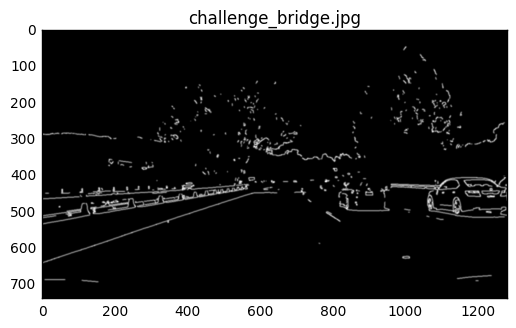

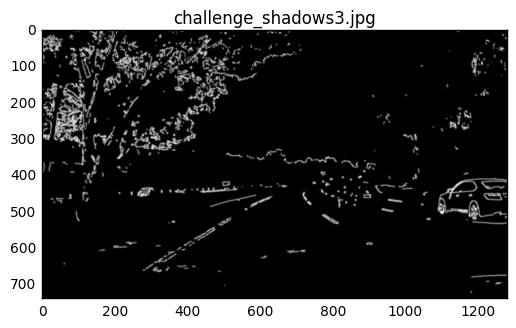

In [94]:
test_list = os.listdir("test_images/")
for file in test_list:
    if "challenge" not in file:
        continue
    img = mpimg.imread('test_images/' + file)
    print('This image is:', type(img), 'with dimensions:', img.shape)
    after_img = canny(img, 400, 300)
    after_img = gaussian_noise(after_img, 9)
    plt.figure()
    plt.title(file)
    plt.imshow(after_img, cmap="gray")

In [179]:
challenge_output = 'extra2.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_challenge_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra2.mp4
[MoviePy] Writing video extra2.mp4


100%|██████████| 251/251 [00:13<00:00, 18.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra2.mp4 

CPU times: user 25.2 s, sys: 883 ms, total: 26.1 s
Wall time: 14.2 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

### Range Thresholding

This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)


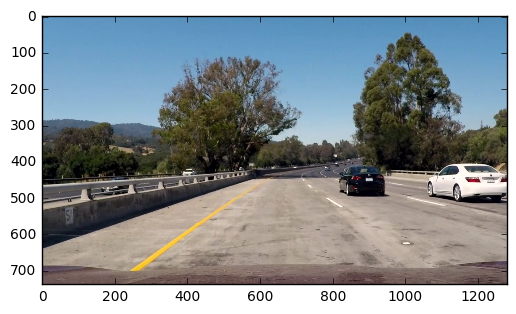

In [196]:
#reading in an image
image = mpimg.imread('test_images/challenge_bridge.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

In [132]:
def threshold_yellow(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # define range of yellow color in HSV
    lower_yellow = np.array([80,125,125])
    upper_yellow = np.array([100,255,255])

    # Threshold the HSV image to get only yellow colors
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

    return mask

This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)


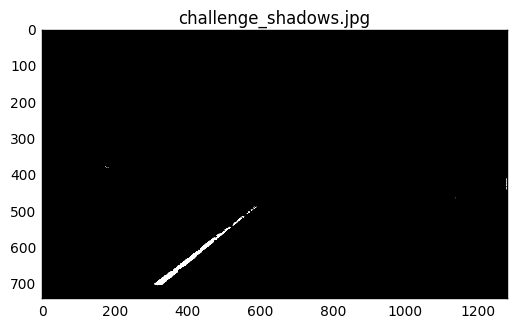

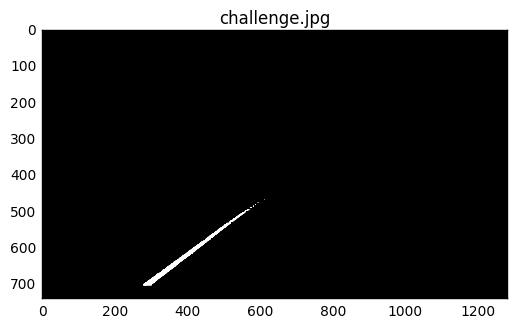

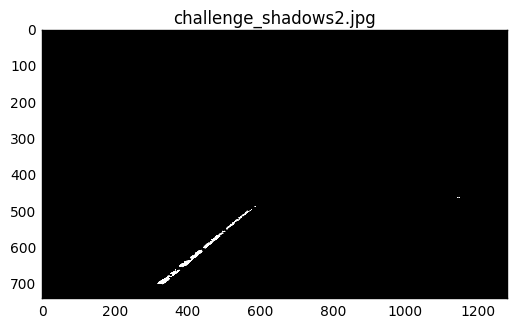

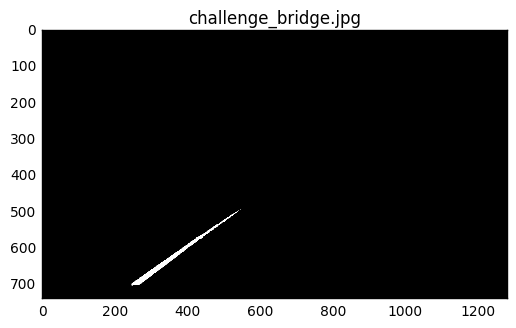

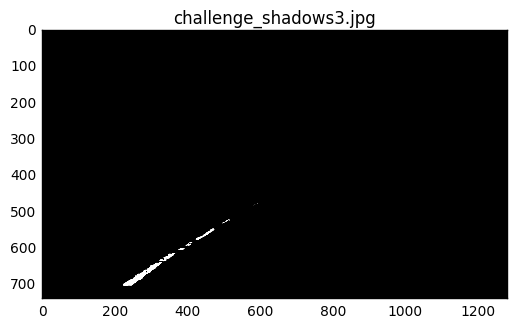

In [133]:
test_list = os.listdir("test_images/")
for file in test_list:
    if "challenge" not in file:
        continue
    img = mpimg.imread('test_images/' + file)
    print('This image is:', type(img), 'with dimensions:', img.shape)
    thresh = threshold_yellow(img)
    plt.figure()
    plt.title(file)
    plt.imshow(thresh, cmap="gray")

In [349]:
def threshold_white(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # define range of white color in HSV
    lower_white = np.array([0,0,200])
    upper_white = np.array([150,50,255])

    # Threshold the HSV image to get only white colors
    mask = cv2.inRange(hsv, lower_white, upper_white)

    return mask

This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)


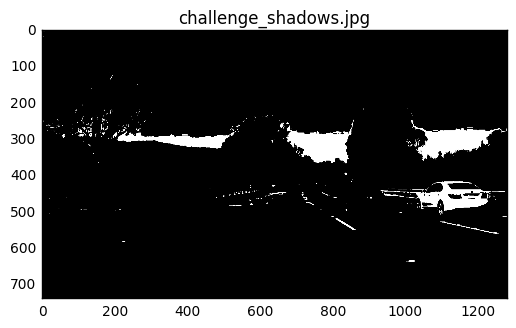

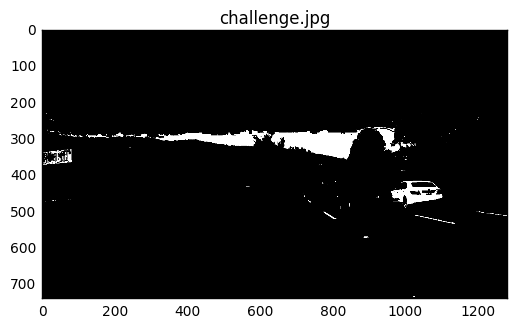

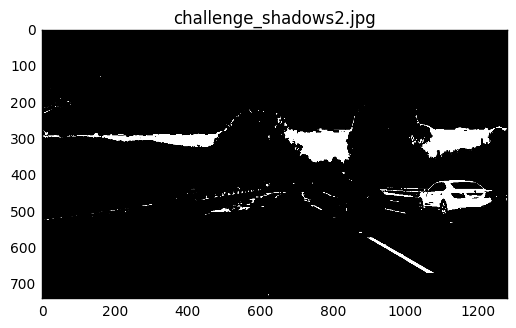

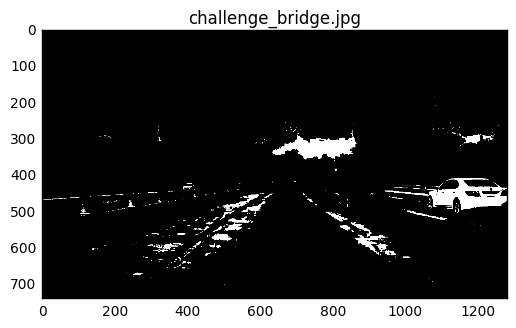

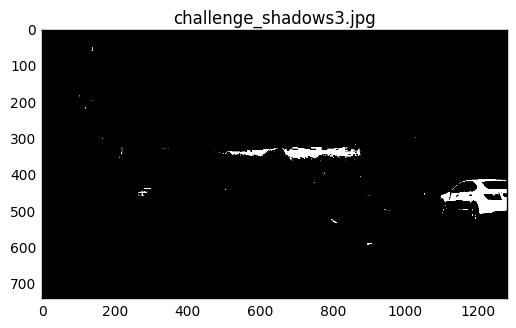

In [350]:
test_list = os.listdir("test_images/")
for file in test_list:
    if "challenge" not in file:
        continue
    img = mpimg.imread('test_images/' + file)
    print('This image is:', type(img), 'with dimensions:', img.shape)
    thresh = threshold_white(img)
    plt.figure()
    plt.title(file)
    plt.imshow(thresh, cmap="gray")

In [289]:
def threshold_white_and_yellow(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # define range of white color in HSV
    lower_white = np.array([90,0,230])
    upper_white = np.array([110,20,255])

    # define range of yellow color in HSV
    lower_yellow = np.array([80,50,50])
    upper_yellow = np.array([100,255,255])

    # Threshold the HSV image to get only white colors
    mask_white = cv2.inRange(hsv, lower_white, upper_white)
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    return mask_white + mask_yellow

This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)


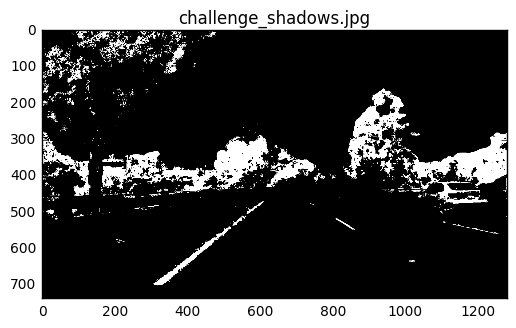

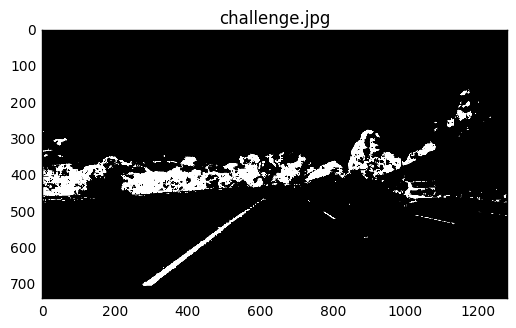

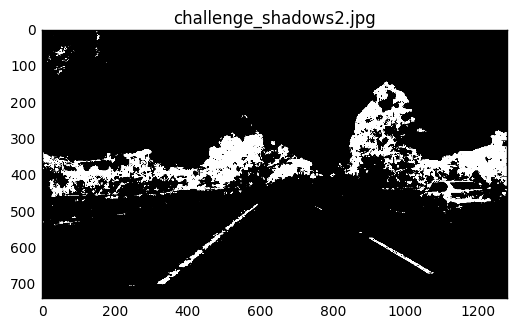

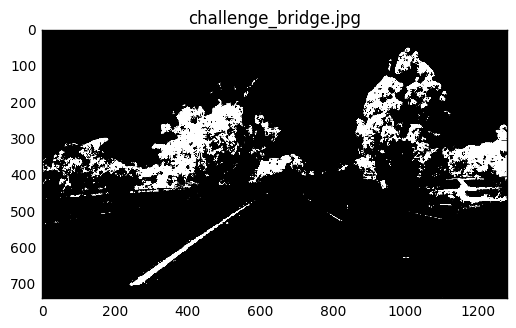

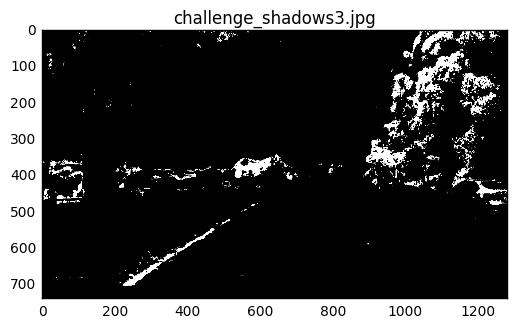

In [323]:
test_list = os.listdir("test_images/")
for file in test_list:
    if "challenge" not in file:
        continue
    img = mpimg.imread('test_images/' + file)
    print('This image is:', type(img), 'with dimensions:', img.shape)
    thresh = threshold_white_and_yellow(img)
    plt.figure()
    plt.title(file)
    plt.imshow(thresh, cmap="gray")

In [318]:
def process_challenge_image(image):
    # Threshold for white and yellow values
    thresholded_image = threshold_white_and_yellow(image)
    
    # Mask the Region of Interest
    vertices = np.array([[(120, 738), (580, 450), (740, 450), (1250, 738)]])
    masked_image = region_of_interest(thresholded_image, vertices)

    # Apply a Gaussian Noise filter
    gaussian_image = gaussian_noise(masked_image, 9)

    # Draw the Hough Lines
    hough_image = hough_lines_to_bottom(gaussian_image, rho = 1, theta = np.pi / 180, threshold = 50,
                          min_line_len = 20, max_line_gap = 70)

    # Transform the hough_image into the same channel space.
    # Or else, cv2.addWeighted will fail.
    hough_image_BGR = cv2.cvtColor(hough_image, cv2.COLOR_GRAY2BGR)

    # Make the Hough Lines pink, because I like pink.
    b,g,r = cv2.split(hough_image_BGR)
    g = 0 * g
    b * 0.5 * b
    hough_image_pink = cv2.merge((b, g, r))
    # See, e.g., http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_core/py_basic_ops/py_basic_ops.html

    # Superimpose the Hough Lines on the original image
    # Using the default parameters for α, β, and λ
    superimposed_image = weighted_img(hough_image_pink, image, α=0.8, β=1., λ=0.1)

    return superimposed_image

This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (738, 1280, 3)


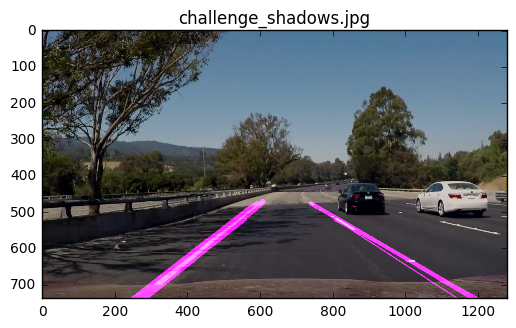

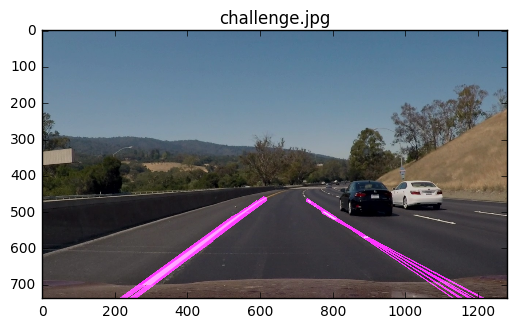

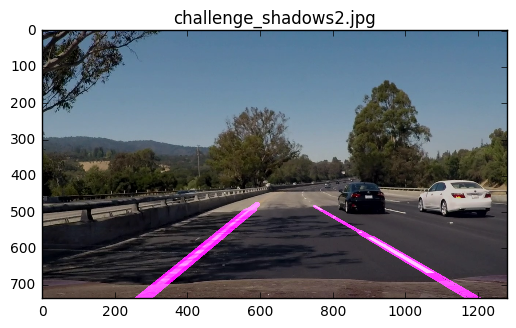

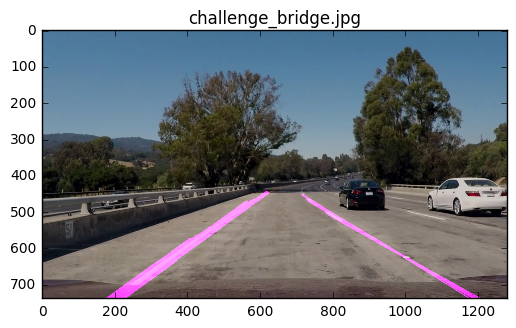

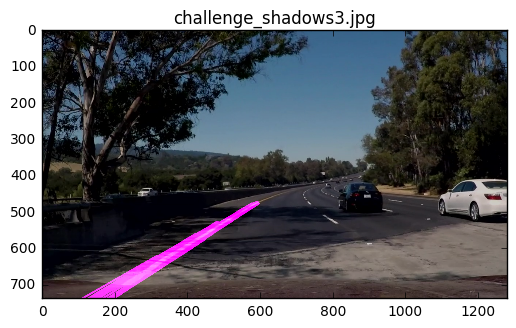

In [322]:
test_list = os.listdir("test_images/")
for file in test_list:
    if "challenge" not in file:
        continue
    img = mpimg.imread('test_images/' + file)
    print('This image is:', type(img), 'with dimensions:', img.shape)
    after_img = process_challenge_image(img)
    plt.figure()
    plt.title(file)
    plt.imshow(after_img, cmap="gray")

In [320]:
challenge_output = 'extra3.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_challenge_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra3.mp4
[MoviePy] Writing video extra3.mp4


100%|██████████| 251/251 [00:12<00:00, 19.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra3.mp4 

CPU times: user 15.9 s, sys: 623 ms, total: 16.5 s
Wall time: 14 s


In [321]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))